## **EXERCÍCIO 07 - Data Augmentation**

## **CESAR SCHOOL**
* Pós-graduação em Engenharia e Análise de Dados - 2023.2
* **Disciplina: Tópicos Complementares**
* Professor: **Silvan Ferreira**
* Aluno: **Allan Bispo** - apsb@cesar.school

In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [3]:
def train_model(model, trainloader, valloader, criterion, optimizer, device, num_epochs=5):
    history = {
        'train_losses': [],
        'val_losses': [],
        'train_accuracies': [],
        'val_accuracies': []
    }

    for epoch in range(num_epochs):
        # Treinamento
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for i, data in tqdm(enumerate(trainloader, 0), total=len(trainloader)):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(trainloader)
        train_acc = 100 * correct / total
        history['train_losses'].append(train_loss)
        history['train_accuracies'].append(train_acc)
        print(f'Epoch {epoch+1}, Train Loss: {train_loss:.3f}, Train Accuracy: {train_acc:.2f}%')

        # Validação
        model.eval()
        val_running_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for data in valloader:
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss = val_running_loss / len(valloader)
        val_acc = 100 * correct / total
        history['val_losses'].append(val_loss)
        history['val_accuracies'].append(val_acc)
        print(f'Epoch {epoch+1}, Val Loss: {val_loss:.3f}, Val Accuracy: {val_acc:.2f}%')

    print('Treinamento concluído')
    return history


def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    ax1.plot(history['train_losses'], label='Train')
    ax1.plot(history['val_losses'], label='Validation')
    ax1.set_title('Loss')
    ax1.legend()

    ax2.plot(history['train_accuracies'], label='Train')
    ax2.plot(history['val_accuracies'], label='Validation')
    ax2.set_title('Accuracy')
    ax2.legend()

    plt.show()


def test_model(model, testloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Acurácia da rede na base de teste: {100 * correct / total:.2f}%')

In [4]:
# Baixa e extrai o dataset
!curl -L -o data/animais.zip "https://drive.google.com/uc?export=download&id=16Lll0Slg1unWxAb26AzZqI9sPdB_fYpV"
!unzip data/animais.zip -d data

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 11.6M  100 11.6M    0     0  1917k      0  0:00:06  0:00:06 --:--:-- 3068k
Archive:  data/animais.zip
   creating: data/animais/
   creating: data/animais/val/
   creating: data/animais/val/tatu/
  inflating: data/animais/val/tatu/10242.jpg  
  inflating: data/animais/val/tatu/10209.jpg  
  inflating: data/animais/val/tatu/10251.jpg  
  inflating: data/animais/val/tatu/10202.jpg  
  inflating: data/animais/val/tatu/10243.jpg  
  inflating: data/animais/val/tatu/10215.jpg  
  inflating: data/animais/val/tatu/10254.jpg  
  inflating: data/animais/val/tatu/10241.jpg  
  inflating: data/animais/val/tatu/10238.jpg  
  inflating: data/animais/val/tatu/10228.jpg  
  inflating: data/animais/val/tatu/10203.jpg  
  inflating: data/animais/val/tatu/10236.jpg  

In [5]:
# Carregando os datasets
transform_aug = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_no_aug = transforms.Compose([
    transforms.Resize(230),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

data_dir = "data/animais"

train_set = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform_aug)
val_set = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=transform_no_aug)

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=True)

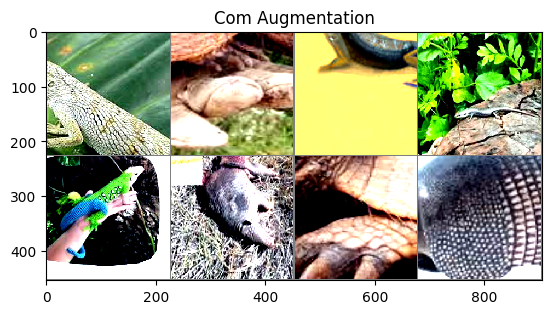

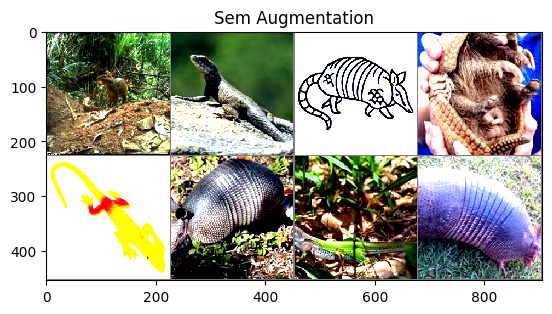

In [ ]:
def imshow(img, title=None):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), interpolation='none')
    if title is not None:
        plt.title(title)
    plt.show()

# Função para mostrar exemplos
def show_examples(loader, title):
    images, labels = next(iter(loader))
    images = images[:8]
    labels = labels[:8]
    imshow(torchvision.utils.make_grid(images, nrow=4), title)

# Mostrando exemplos com e sem data augmentation
show_examples(train_loader, title="Com Augmentation")
show_examples(val_loader, title="Sem Augmentation")

In [ ]:
class CNN(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 8, kernel_size=5, stride=2, padding=0)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=5, stride=2, padding=0)
        self.fc1 = nn.Linear(16 * 13 * 13, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), kernel_size=2, stride=2, padding=0)
        x = F.max_pool2d(F.relu(self.conv2(x)), kernel_size=2, stride=2, padding=0)
        x = x.view(-1, 16 * 13 * 13)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = CNN(num_classes=2).to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [ ]:
# Treinando a CNN
history = train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=30)

100%|██████████| 13/13 [00:02<00:00,  5.12it/s]
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1, Train Loss: 0.694, Train Accuracy: 48.25%
Epoch 1, Val Loss: 0.689, Val Accuracy: 56.56%


100%|██████████| 13/13 [00:02<00:00,  5.95it/s]


Epoch 2, Train Loss: 0.693, Train Accuracy: 52.50%
Epoch 2, Val Loss: 0.688, Val Accuracy: 69.67%


100%|██████████| 13/13 [00:02<00:00,  5.93it/s]


Epoch 3, Train Loss: 0.691, Train Accuracy: 52.25%
Epoch 3, Val Loss: 0.685, Val Accuracy: 64.75%


100%|██████████| 13/13 [00:02<00:00,  4.81it/s]


Epoch 4, Train Loss: 0.688, Train Accuracy: 57.00%
Epoch 4, Val Loss: 0.678, Val Accuracy: 64.75%


100%|██████████| 13/13 [00:02<00:00,  5.99it/s]


Epoch 5, Train Loss: 0.684, Train Accuracy: 57.75%
Epoch 5, Val Loss: 0.663, Val Accuracy: 68.85%


100%|██████████| 13/13 [00:02<00:00,  6.00it/s]


Epoch 6, Train Loss: 0.687, Train Accuracy: 53.75%
Epoch 6, Val Loss: 0.659, Val Accuracy: 61.48%


100%|██████████| 13/13 [00:03<00:00,  3.99it/s]


Epoch 7, Train Loss: 0.675, Train Accuracy: 58.00%
Epoch 7, Val Loss: 0.633, Val Accuracy: 70.49%


100%|██████████| 13/13 [00:02<00:00,  5.48it/s]


Epoch 8, Train Loss: 0.668, Train Accuracy: 60.25%
Epoch 8, Val Loss: 0.646, Val Accuracy: 58.20%


100%|██████████| 13/13 [00:02<00:00,  6.04it/s]


Epoch 9, Train Loss: 0.705, Train Accuracy: 50.75%
Epoch 9, Val Loss: 0.647, Val Accuracy: 67.21%


100%|██████████| 13/13 [00:02<00:00,  6.00it/s]


Epoch 10, Train Loss: 0.676, Train Accuracy: 59.75%
Epoch 10, Val Loss: 0.648, Val Accuracy: 66.39%


100%|██████████| 13/13 [00:03<00:00,  4.32it/s]


Epoch 11, Train Loss: 0.687, Train Accuracy: 55.25%
Epoch 11, Val Loss: 0.667, Val Accuracy: 55.74%


100%|██████████| 13/13 [00:03<00:00,  3.76it/s]


Epoch 12, Train Loss: 0.672, Train Accuracy: 61.75%
Epoch 12, Val Loss: 0.626, Val Accuracy: 67.21%


100%|██████████| 13/13 [00:04<00:00,  3.25it/s]


Epoch 13, Train Loss: 0.664, Train Accuracy: 63.50%
Epoch 13, Val Loss: 0.589, Val Accuracy: 76.23%


100%|██████████| 13/13 [00:02<00:00,  5.35it/s]


Epoch 14, Train Loss: 0.652, Train Accuracy: 63.50%
Epoch 14, Val Loss: 0.568, Val Accuracy: 77.87%


100%|██████████| 13/13 [00:02<00:00,  6.05it/s]


Epoch 15, Train Loss: 0.642, Train Accuracy: 63.75%
Epoch 15, Val Loss: 0.549, Val Accuracy: 78.69%


100%|██████████| 13/13 [00:02<00:00,  5.99it/s]


Epoch 16, Train Loss: 0.639, Train Accuracy: 63.00%
Epoch 16, Val Loss: 0.564, Val Accuracy: 78.69%


100%|██████████| 13/13 [00:02<00:00,  5.20it/s]


Epoch 17, Train Loss: 0.660, Train Accuracy: 61.75%
Epoch 17, Val Loss: 0.588, Val Accuracy: 72.95%


100%|██████████| 13/13 [00:02<00:00,  5.83it/s]


Epoch 18, Train Loss: 0.654, Train Accuracy: 62.25%
Epoch 18, Val Loss: 0.612, Val Accuracy: 68.85%


100%|██████████| 13/13 [00:02<00:00,  6.08it/s]


Epoch 19, Train Loss: 0.653, Train Accuracy: 62.75%
Epoch 19, Val Loss: 0.555, Val Accuracy: 74.59%


100%|██████████| 13/13 [00:02<00:00,  6.06it/s]


Epoch 20, Train Loss: 0.660, Train Accuracy: 62.25%
Epoch 20, Val Loss: 0.571, Val Accuracy: 73.77%


100%|██████████| 13/13 [00:04<00:00,  3.09it/s]


Epoch 21, Train Loss: 0.627, Train Accuracy: 67.25%
Epoch 21, Val Loss: 0.548, Val Accuracy: 77.87%


100%|██████████| 13/13 [00:02<00:00,  5.86it/s]


Epoch 22, Train Loss: 0.637, Train Accuracy: 63.25%
Epoch 22, Val Loss: 0.532, Val Accuracy: 75.41%


100%|██████████| 13/13 [00:02<00:00,  5.09it/s]


Epoch 23, Train Loss: 0.634, Train Accuracy: 64.50%
Epoch 23, Val Loss: 0.564, Val Accuracy: 73.77%


100%|██████████| 13/13 [00:02<00:00,  4.93it/s]


Epoch 24, Train Loss: 0.613, Train Accuracy: 67.75%
Epoch 24, Val Loss: 0.557, Val Accuracy: 73.77%


100%|██████████| 13/13 [00:02<00:00,  6.02it/s]


Epoch 25, Train Loss: 0.604, Train Accuracy: 68.25%
Epoch 25, Val Loss: 0.522, Val Accuracy: 74.59%


100%|██████████| 13/13 [00:02<00:00,  5.97it/s]


Epoch 26, Train Loss: 0.618, Train Accuracy: 66.00%
Epoch 26, Val Loss: 0.527, Val Accuracy: 73.77%


100%|██████████| 13/13 [00:02<00:00,  5.89it/s]


Epoch 27, Train Loss: 0.595, Train Accuracy: 67.25%
Epoch 27, Val Loss: 0.589, Val Accuracy: 68.85%


100%|██████████| 13/13 [00:03<00:00,  4.26it/s]


Epoch 28, Train Loss: 0.627, Train Accuracy: 65.00%
Epoch 28, Val Loss: 0.592, Val Accuracy: 67.21%


100%|██████████| 13/13 [00:02<00:00,  6.09it/s]


Epoch 29, Train Loss: 0.628, Train Accuracy: 64.25%
Epoch 29, Val Loss: 0.586, Val Accuracy: 70.49%


100%|██████████| 13/13 [00:02<00:00,  5.98it/s]


Epoch 30, Train Loss: 0.617, Train Accuracy: 68.50%
Epoch 30, Val Loss: 0.554, Val Accuracy: 72.13%
Treinamento concluído


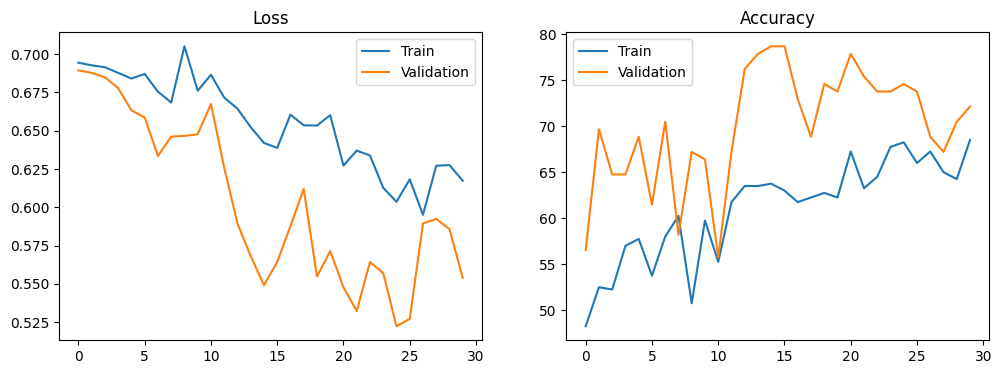

In [ ]:
plot_history(history)

## Exercícios

### Exercício 1
Quais transformações podem ser adicionadas ainda ao processo de data augmentation deste problema? Entre na documentação em https://pytorch.org/vision/stable/transforms.html e escolha, defina os parâmetros e treine novamente o modelo com no mínimo 3 novas transformações.

####RESPOSTA:
* Para o exercício serão adicionados os transformers: 'ColorJitter', 'RandomRotation' e 'RandomErasing'.
* A idéia foi aplicar transformações adicionais que melhorassem a performance do modelo.
* As transformações "Color Jitter", "Random Rotation" e "Random Erasing" alteram aleatoriamente as condições de iluminação, orientação e visibilidade das imagens, ajudando o modelo a generalizar melhor ao torná-lo mais robusto a variações de cor, rotação e partes ocluídas das imagens.

In [ ]:
# Adicionando transformações
transform_aug_add = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.2),
    transforms.RandomRotation(degrees=20),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3))
])

# Mantendo transformações sem aumento
transform_no_aug = transforms.Compose([
    transforms.Resize(230),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [ ]:
# Aplicando novos transformers ao dataset de treino
train_set_add = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform_aug_add)
val_set = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=transform_no_aug)

# Carregando dataset com transformers adicionais
train_loader_add = DataLoader(train_set_add, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=True)

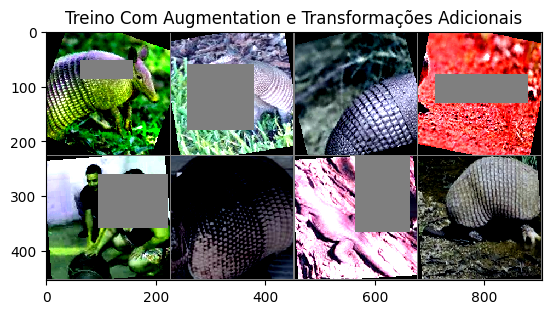

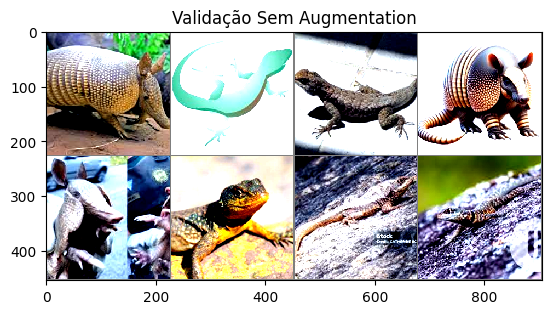

In [ ]:
# Mostrando exemplos com data augmentation com transformers adicionais e sem data augmentation
show_examples(train_loader_add, title="Treino Com Augmentation e Transformações Adicionais")
show_examples(val_loader, title="Validação Sem Augmentation")

In [ ]:
# Treinando a CNN com os transformers adicionais
history_add = train_model(model, train_loader_add, val_loader, criterion, optimizer, device, num_epochs=30)

100%|██████████| 13/13 [00:04<00:00,  2.72it/s]


Epoch 1, Train Loss: 0.681, Train Accuracy: 60.00%


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1, Val Loss: 0.636, Val Accuracy: 64.75%


100%|██████████| 13/13 [00:05<00:00,  2.48it/s]


Epoch 2, Train Loss: 0.691, Train Accuracy: 54.25%
Epoch 2, Val Loss: 0.643, Val Accuracy: 65.57%


100%|██████████| 13/13 [00:04<00:00,  2.68it/s]


Epoch 3, Train Loss: 0.661, Train Accuracy: 60.25%
Epoch 3, Val Loss: 0.599, Val Accuracy: 67.21%


100%|██████████| 13/13 [00:05<00:00,  2.54it/s]


Epoch 4, Train Loss: 0.660, Train Accuracy: 58.00%
Epoch 4, Val Loss: 0.595, Val Accuracy: 67.21%


100%|██████████| 13/13 [00:04<00:00,  2.65it/s]


Epoch 5, Train Loss: 0.639, Train Accuracy: 62.00%
Epoch 5, Val Loss: 0.615, Val Accuracy: 63.11%


100%|██████████| 13/13 [00:05<00:00,  2.56it/s]


Epoch 6, Train Loss: 0.678, Train Accuracy: 56.50%
Epoch 6, Val Loss: 0.607, Val Accuracy: 68.03%


100%|██████████| 13/13 [00:04<00:00,  2.64it/s]


Epoch 7, Train Loss: 0.660, Train Accuracy: 60.25%
Epoch 7, Val Loss: 0.618, Val Accuracy: 67.21%


100%|██████████| 13/13 [00:05<00:00,  2.58it/s]


Epoch 8, Train Loss: 0.668, Train Accuracy: 59.25%
Epoch 8, Val Loss: 0.614, Val Accuracy: 68.85%


100%|██████████| 13/13 [00:04<00:00,  2.61it/s]


Epoch 9, Train Loss: 0.674, Train Accuracy: 55.50%
Epoch 9, Val Loss: 0.607, Val Accuracy: 72.95%


100%|██████████| 13/13 [00:04<00:00,  2.67it/s]


Epoch 10, Train Loss: 0.665, Train Accuracy: 58.75%
Epoch 10, Val Loss: 0.605, Val Accuracy: 72.95%


100%|██████████| 13/13 [00:05<00:00,  2.53it/s]


Epoch 11, Train Loss: 0.644, Train Accuracy: 63.25%
Epoch 11, Val Loss: 0.584, Val Accuracy: 66.39%


100%|██████████| 13/13 [00:04<00:00,  2.73it/s]


Epoch 12, Train Loss: 0.674, Train Accuracy: 59.50%
Epoch 12, Val Loss: 0.601, Val Accuracy: 71.31%


100%|██████████| 13/13 [00:06<00:00,  2.07it/s]


Epoch 13, Train Loss: 0.666, Train Accuracy: 60.25%
Epoch 13, Val Loss: 0.622, Val Accuracy: 64.75%


100%|██████████| 13/13 [00:08<00:00,  1.57it/s]


Epoch 14, Train Loss: 0.658, Train Accuracy: 63.00%
Epoch 14, Val Loss: 0.623, Val Accuracy: 66.39%


100%|██████████| 13/13 [00:06<00:00,  1.93it/s]


Epoch 15, Train Loss: 0.655, Train Accuracy: 59.75%
Epoch 15, Val Loss: 0.607, Val Accuracy: 64.75%


100%|██████████| 13/13 [00:06<00:00,  1.97it/s]


Epoch 16, Train Loss: 0.638, Train Accuracy: 62.00%
Epoch 16, Val Loss: 0.611, Val Accuracy: 62.30%


100%|██████████| 13/13 [00:06<00:00,  2.05it/s]


Epoch 17, Train Loss: 0.644, Train Accuracy: 61.75%
Epoch 17, Val Loss: 0.603, Val Accuracy: 68.03%


100%|██████████| 13/13 [00:05<00:00,  2.18it/s]


Epoch 18, Train Loss: 0.667, Train Accuracy: 58.50%
Epoch 18, Val Loss: 0.580, Val Accuracy: 71.31%


100%|██████████| 13/13 [00:05<00:00,  2.17it/s]


Epoch 19, Train Loss: 0.643, Train Accuracy: 61.50%
Epoch 19, Val Loss: 0.601, Val Accuracy: 72.95%


100%|██████████| 13/13 [00:05<00:00,  2.38it/s]


Epoch 20, Train Loss: 0.650, Train Accuracy: 62.25%
Epoch 20, Val Loss: 0.586, Val Accuracy: 68.03%


100%|██████████| 13/13 [00:06<00:00,  2.03it/s]


Epoch 21, Train Loss: 0.668, Train Accuracy: 59.25%
Epoch 21, Val Loss: 0.588, Val Accuracy: 69.67%


100%|██████████| 13/13 [00:05<00:00,  2.30it/s]


Epoch 22, Train Loss: 0.645, Train Accuracy: 64.25%
Epoch 22, Val Loss: 0.587, Val Accuracy: 69.67%


100%|██████████| 13/13 [00:06<00:00,  2.05it/s]


Epoch 23, Train Loss: 0.635, Train Accuracy: 63.75%
Epoch 23, Val Loss: 0.603, Val Accuracy: 68.03%


100%|██████████| 13/13 [00:06<00:00,  2.00it/s]


Epoch 24, Train Loss: 0.661, Train Accuracy: 60.25%
Epoch 24, Val Loss: 0.590, Val Accuracy: 69.67%


100%|██████████| 13/13 [00:04<00:00,  2.60it/s]


Epoch 25, Train Loss: 0.652, Train Accuracy: 59.50%
Epoch 25, Val Loss: 0.575, Val Accuracy: 69.67%


100%|██████████| 13/13 [00:04<00:00,  2.69it/s]


Epoch 26, Train Loss: 0.659, Train Accuracy: 63.00%
Epoch 26, Val Loss: 0.547, Val Accuracy: 76.23%


100%|██████████| 13/13 [00:05<00:00,  2.54it/s]


Epoch 27, Train Loss: 0.658, Train Accuracy: 62.25%
Epoch 27, Val Loss: 0.568, Val Accuracy: 71.31%


100%|██████████| 13/13 [00:04<00:00,  2.74it/s]


Epoch 28, Train Loss: 0.649, Train Accuracy: 61.50%
Epoch 28, Val Loss: 0.557, Val Accuracy: 72.95%


100%|██████████| 13/13 [00:05<00:00,  2.43it/s]


Epoch 29, Train Loss: 0.648, Train Accuracy: 64.00%
Epoch 29, Val Loss: 0.547, Val Accuracy: 72.95%


100%|██████████| 13/13 [00:04<00:00,  2.72it/s]


Epoch 30, Train Loss: 0.651, Train Accuracy: 62.50%
Epoch 30, Val Loss: 0.575, Val Accuracy: 70.49%
Treinamento concluído


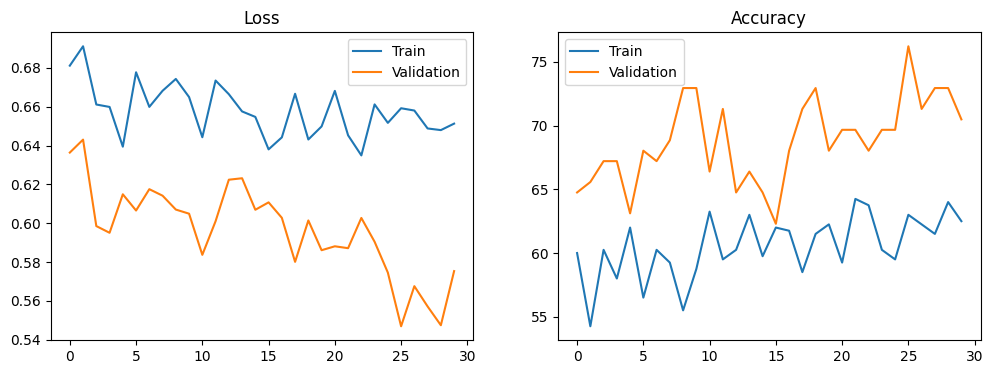

In [ ]:
# Plotando as perdas e acurácia com os transformers adicionais
plot_history(history_add)

####RESULTADOS DA ADIÇÃO DE TRANSFORMERS:
* A adição dos transformers resultou numa performance de loss e accuracy melhores nas épocas iniciais, todavia há uma estabilização ao final, levando as curvas praticamente ao mesmo resultado do treino original.

####AJUSTES DE PARÂMETROS DOS TRANSFORMERS
* Abaixo uma tentativa de ajustes de parâmetros para melhorar o desempenho como um todo.
* Com o fine tunning dos parâmetros os transformers resultaram em loss e accuracy melhores durante todas as épocas.

In [ ]:
# Ajustando as transformações
transform_aug_add_ajuste = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)), # ajustado
    transforms.RandomHorizontalFlip(p=0.7), # ajustado
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), # ajustado
    transforms.RandomRotation(degrees=10), # ajustado
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.2), ratio=(0.4, 2.5)) # ajustado
])

# Mantendo transformações sem aumento
transform_no_aug = transforms.Compose([
    transforms.Resize(230),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [ ]:
# Aplicando novos transformers ao dataset de treino - AJUSTADO
train_set_add_ajuste = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform_aug_add)
val_set = datasets.ImageFolder(os.path.join(data_dir, 'val'), transform=transform_no_aug)

# Carregando dataset com transformers adicionais - AJUSTADO
train_loader_add_ajuste = DataLoader(train_set_add_ajuste, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=True)

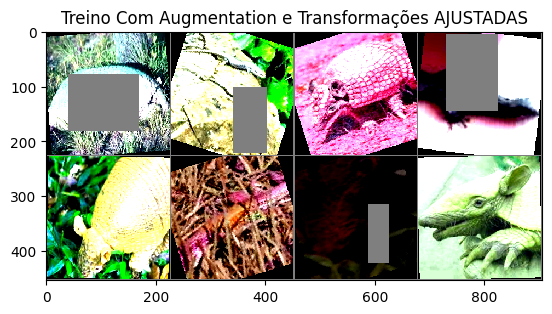

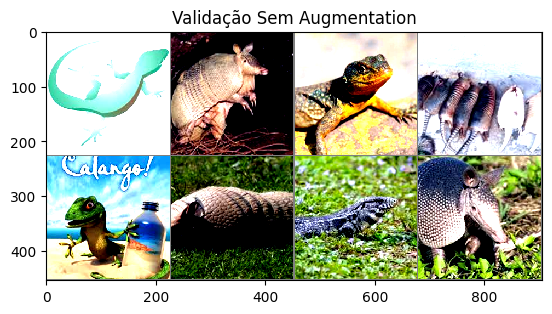

In [ ]:
# Mostrando exemplos com data augmentation com transformers adicionais e sem data augmentation - AJUSTADO
show_examples(train_loader_add_ajuste, title="Treino Com Augmentation e Transformações AJUSTADAS")
show_examples(val_loader, title="Validação Sem Augmentation")

In [ ]:
# Treinando a CNN com os transformers adicionais - AJUSTADO
history_add_ajuste = train_model(model, train_loader_add_ajuste, val_loader, criterion, optimizer, device, num_epochs=30)

100%|██████████| 13/13 [00:04<00:00,  2.62it/s]


Epoch 1, Train Loss: 0.649, Train Accuracy: 59.25%
Epoch 1, Val Loss: 0.499, Val Accuracy: 75.41%


100%|██████████| 13/13 [00:04<00:00,  2.61it/s]


Epoch 2, Train Loss: 0.630, Train Accuracy: 65.25%
Epoch 2, Val Loss: 0.521, Val Accuracy: 73.77%


100%|██████████| 13/13 [00:04<00:00,  2.60it/s]


Epoch 3, Train Loss: 0.633, Train Accuracy: 63.75%
Epoch 3, Val Loss: 0.530, Val Accuracy: 70.49%


100%|██████████| 13/13 [00:04<00:00,  2.70it/s]


Epoch 4, Train Loss: 0.618, Train Accuracy: 65.25%
Epoch 4, Val Loss: 0.518, Val Accuracy: 69.67%


100%|██████████| 13/13 [00:05<00:00,  2.52it/s]


Epoch 5, Train Loss: 0.623, Train Accuracy: 63.25%
Epoch 5, Val Loss: 0.498, Val Accuracy: 73.77%


100%|██████████| 13/13 [00:04<00:00,  2.71it/s]


Epoch 6, Train Loss: 0.617, Train Accuracy: 65.75%
Epoch 6, Val Loss: 0.543, Val Accuracy: 70.49%


100%|██████████| 13/13 [00:05<00:00,  2.40it/s]


Epoch 7, Train Loss: 0.625, Train Accuracy: 64.50%
Epoch 7, Val Loss: 0.512, Val Accuracy: 74.59%


100%|██████████| 13/13 [00:04<00:00,  2.70it/s]


Epoch 8, Train Loss: 0.626, Train Accuracy: 64.25%
Epoch 8, Val Loss: 0.514, Val Accuracy: 75.41%


100%|██████████| 13/13 [00:05<00:00,  2.33it/s]


Epoch 9, Train Loss: 0.627, Train Accuracy: 65.25%
Epoch 9, Val Loss: 0.547, Val Accuracy: 73.77%


100%|██████████| 13/13 [00:04<00:00,  2.73it/s]


Epoch 10, Train Loss: 0.642, Train Accuracy: 61.00%
Epoch 10, Val Loss: 0.561, Val Accuracy: 72.95%


100%|██████████| 13/13 [00:05<00:00,  2.31it/s]


Epoch 11, Train Loss: 0.628, Train Accuracy: 63.75%
Epoch 11, Val Loss: 0.493, Val Accuracy: 78.69%


100%|██████████| 13/13 [00:04<00:00,  2.77it/s]


Epoch 12, Train Loss: 0.609, Train Accuracy: 64.50%
Epoch 12, Val Loss: 0.483, Val Accuracy: 76.23%


100%|██████████| 13/13 [00:05<00:00,  2.31it/s]


Epoch 13, Train Loss: 0.610, Train Accuracy: 64.50%
Epoch 13, Val Loss: 0.530, Val Accuracy: 74.59%


100%|██████████| 13/13 [00:04<00:00,  2.74it/s]


Epoch 14, Train Loss: 0.634, Train Accuracy: 63.50%
Epoch 14, Val Loss: 0.484, Val Accuracy: 78.69%


100%|██████████| 13/13 [00:05<00:00,  2.25it/s]


Epoch 15, Train Loss: 0.609, Train Accuracy: 64.25%
Epoch 15, Val Loss: 0.529, Val Accuracy: 70.49%


100%|██████████| 13/13 [00:04<00:00,  2.76it/s]


Epoch 16, Train Loss: 0.618, Train Accuracy: 64.25%
Epoch 16, Val Loss: 0.512, Val Accuracy: 76.23%


100%|██████████| 13/13 [00:05<00:00,  2.36it/s]


Epoch 17, Train Loss: 0.607, Train Accuracy: 69.00%
Epoch 17, Val Loss: 0.502, Val Accuracy: 74.59%


100%|██████████| 13/13 [00:04<00:00,  2.73it/s]


Epoch 18, Train Loss: 0.628, Train Accuracy: 64.75%
Epoch 18, Val Loss: 0.513, Val Accuracy: 70.49%


100%|██████████| 13/13 [00:05<00:00,  2.36it/s]


Epoch 19, Train Loss: 0.601, Train Accuracy: 65.75%
Epoch 19, Val Loss: 0.511, Val Accuracy: 73.77%


100%|██████████| 13/13 [00:04<00:00,  2.73it/s]


Epoch 20, Train Loss: 0.620, Train Accuracy: 67.50%
Epoch 20, Val Loss: 0.539, Val Accuracy: 70.49%


100%|██████████| 13/13 [00:05<00:00,  2.34it/s]


Epoch 21, Train Loss: 0.593, Train Accuracy: 69.50%
Epoch 21, Val Loss: 0.537, Val Accuracy: 73.77%


100%|██████████| 13/13 [00:04<00:00,  2.73it/s]


Epoch 22, Train Loss: 0.603, Train Accuracy: 69.00%
Epoch 22, Val Loss: 0.543, Val Accuracy: 72.95%


100%|██████████| 13/13 [00:05<00:00,  2.35it/s]


Epoch 23, Train Loss: 0.621, Train Accuracy: 64.75%
Epoch 23, Val Loss: 0.514, Val Accuracy: 72.95%


100%|██████████| 13/13 [00:04<00:00,  2.73it/s]


Epoch 24, Train Loss: 0.606, Train Accuracy: 67.25%
Epoch 24, Val Loss: 0.510, Val Accuracy: 75.41%


100%|██████████| 13/13 [00:05<00:00,  2.36it/s]


Epoch 25, Train Loss: 0.595, Train Accuracy: 66.25%
Epoch 25, Val Loss: 0.493, Val Accuracy: 80.33%


100%|██████████| 13/13 [00:04<00:00,  2.73it/s]


Epoch 26, Train Loss: 0.617, Train Accuracy: 66.00%
Epoch 26, Val Loss: 0.488, Val Accuracy: 78.69%


100%|██████████| 13/13 [00:05<00:00,  2.35it/s]


Epoch 27, Train Loss: 0.626, Train Accuracy: 62.25%
Epoch 27, Val Loss: 0.487, Val Accuracy: 77.87%


100%|██████████| 13/13 [00:04<00:00,  2.69it/s]


Epoch 28, Train Loss: 0.605, Train Accuracy: 65.50%
Epoch 28, Val Loss: 0.494, Val Accuracy: 77.05%


100%|██████████| 13/13 [00:05<00:00,  2.37it/s]


Epoch 29, Train Loss: 0.633, Train Accuracy: 63.25%
Epoch 29, Val Loss: 0.498, Val Accuracy: 74.59%


100%|██████████| 13/13 [00:04<00:00,  2.72it/s]


Epoch 30, Train Loss: 0.612, Train Accuracy: 66.50%
Epoch 30, Val Loss: 0.502, Val Accuracy: 76.23%
Treinamento concluído


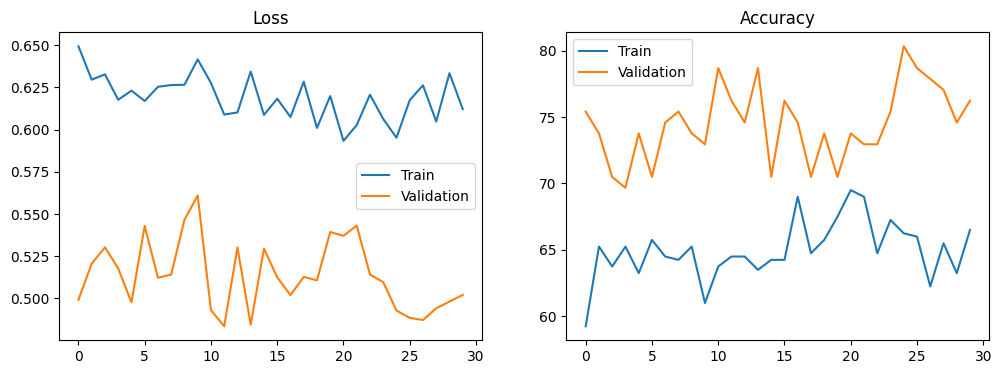

In [ ]:
# Plotando as perdas e acurácia com os transformers adicionais - AJUSTADO
plot_history(history_add_ajuste)